In [1]:
import numpy as np
import pandas as pd
import json
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam

In [3]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"

os.listdir(BASE_DIR)

['test_images',
 'train.csv',
 'test_tfrecords',
 'train_tfrecords',
 'train_images',
 'label_num_to_disease_map.json',
 'sample_submission.csv']

In [4]:
train_data = pd.read_csv(BASE_DIR+'train.csv')
samp_subm = pd.read_csv(BASE_DIR+'sample_submission.csv')

print(train_data)

             image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]


In [5]:
print('number of train data:', len(train_data))
print('number of train images:', len(os.listdir(BASE_DIR+'train_images/')))
print('number of test images:', len(os.listdir(BASE_DIR+'test_images/')))

number of train data: 21397
number of train images: 21397
number of test images: 1


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df['label'] = train_df['label'].astype(str)


train_datagen = ImageDataGenerator(validation_split = 0.2,  #给出验证数据分配比例（validation_split = 0.2）
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)


validation_datagen = ImageDataGenerator(validation_split = 0.2,rescale=1./255) #注意，不能增强验证数据 #给出验证数据分配比例（validation_split = 0.2）

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    subset = "training",#需指定为训练数据
    x_col='image_id',
    y_col='label',
    target_size=(240, 240),
    class_mode='sparse', #使用'sparse' 因为train_df没有使用one-hot
    batch_size=32
)
        # 因为使用了binary_crossentropy损失，所以需要用二进制标签 默认 class_mode='categorical'
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(BASE_DIR, 'train_images'),
    subset = "validation", #需指定为验证数据
    x_col='image_id',
    y_col='label',
    target_size=(240, 240),
    class_mode='sparse', #使用'sparse' 因为train_df没有使用one-hot
    batch_size=32
)

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [7]:
BATCH_SIZE=32
STEPS_PER_EPOCH = len(train_df)*0.8 // BATCH_SIZE
VALIDATION_STEPS = len(train_df)*0.2 // BATCH_SIZE
print(STEPS_PER_EPOCH)
print(VALIDATION_STEPS)

534.0
133.0


In [8]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(240, 240, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) #添加dropout 正则化
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 238, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       1

In [9]:
import keras
callbacks_list = [              #通过fit 的callbacks 参数将回调函数传入模型中，这个参数接收一个回调函数的列表。你可以传入任意个数的回调函数
    keras.callbacks.EarlyStopping(  #如果不再改善，就中断训练
        monitor='val_loss',         #监控模型的val_loss
        patience=4,                 #如果val_loss在多于3轮的时间（即4轮）内不再改善，中断训练
    ),
    keras.callbacks.ModelCheckpoint( #在每轮过后保存当前权重
        filepath='my_model.h5',      #目标模型文件的保存路径
        monitor='val_loss',
        save_best_only=True,        #这两个参数的含义是，如果val_loss 没有改善，那么不需要覆盖模型文件。这就可以始终保存在训练过程中见到的最佳模型
    ),
   
    keras.callbacks.ReduceLROnPlateau(  
        monitor='val_loss',   #监控模型的val_loss 即验证损失
        factor=0.5,           #触发时将学习率除以学习速率设为原来的0.5
        verbose=1,
        patience=2,                 #如果val_loss在多于2轮的时间（即3轮）内不再改善，中断训练，那么就触发这个回调函数
    )
]

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              epochs=1,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=VALIDATION_STEPS,
                              callbacks=callbacks_list) #加入callbacks函数

534/534 [==============================] - 451s 844ms/step - loss: 1.1804 - accuracy: 0.6147 - val_loss: 1.0845 - val_accuracy: 0.6227


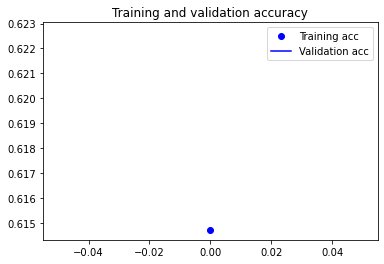

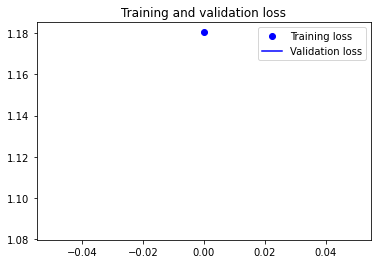

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
filenames = []
labels = []
#for f in os.listdir(os.path.join(BASE_DIR, 'test1')):
for f in os.listdir(os.path.join(BASE_DIR, 'test_images')):
    filenames.append(f)
    labels.append('0')

test_df = pd.DataFrame({
    'image_id': filenames,
    'label': labels,
})

test_datagen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(BASE_DIR, 'test_images'),
    #directory=os.path.join(BASE_DIR, 'test1'),
    x_col='image_id',
    y_col='label',
    target_size=(240, 240)
    
)

y_pred = model.predict(test_datagen)
test_df['label'] = np.argmax(y_pred, axis=1)
test_df.to_csv('submission.csv', index=False)
print(test_df)
print('Done')

Found 1 validated image filenames belonging to 1 classes.
         image_id  label
0  2216849948.jpg      3
Done
